In [11]:
import pandas as pd
import numpy as np
import glob
import os

path = "../tasktwo_/submissions/" 
files = glob.glob(os.path.join(path, "*.csv"))
print(f"Найдено {len(files)} файлов для объединения")

Найдено 8 файлов для объединения


In [12]:
def load_submission(file_path):
    weight = int(os.path.basename(file_path).split(".")[0])
    df = pd.read_csv(file_path)
    df_onehot = pd.get_dummies(df['label'], prefix='label')
    df_onehot = df_onehot * weight
    df_onehot['idx'] = df['idx']
    return df_onehot, weight

sample_df, sample_weight = load_submission(files[0])
sample_df.head(), sample_weight

(   label_0  label_1  label_2  label_3  label_4  label_5  idx
 0      122        0        0        0        0        0    1
 1      122        0        0        0        0        0    2
 2      122        0        0        0        0        0    3
 3        0        0        0        0        0      122    4
 4        0        0        0        0        0      122    5,
 122)

In [13]:
all_data = None
total_weights = {}

for file in files:
    df_onehot, weight = load_submission(file)
    total_weights[file] = weight
    
    if all_data is None:
        all_data = df_onehot
    else:
        all_data = all_data.merge(df_onehot, on='idx', how='outer', suffixes=('', '_dup')).fillna(0)
        for col in df_onehot.columns:
            if col != 'idx' and col + '_dup' in all_data.columns:
                all_data[col] += all_data[col + '_dup']
                all_data.drop(columns=[col + '_dup'], inplace=True)

print("Все файлы объединены с учетом весов")
all_data.head()

Все файлы объединены с учетом весов


,label_0,label_1,label_2,label_3,label_4,label_5,idx
0,959,0,0,0,0,0,1
1,595,126,0,0,0,238,2
2,959,0,0,0,0,0,3
3,0,0,0,0,113,846,4
4,0,0,0,0,0,959,5


In [14]:
label_cols = [c for c in all_data.columns if c.startswith('label_')]
all_data[label_cols] = all_data[label_cols].div(all_data[label_cols].sum(axis=1), axis=0)
all_data.head()

,label_0,label_1,label_2,label_3,label_4,label_5,idx
0,1.000000,0.000000,0.0,0.0,0.000000,0.000000,1
1,0.620438,0.131387,0.0,0.0,0.000000,0.248175,2
2,1.000000,0.000000,0.0,0.0,0.000000,0.000000,3
3,0.000000,0.000000,0.0,0.0,0.117831,0.882169,4
4,0.000000,0.000000,0.0,0.0,0.000000,1.000000,5


In [15]:
all_data['label'] = all_data[label_cols].idxmax(axis=1).str.replace('label_', '').astype(int)
ideal_submission = all_data[['idx', 'label']]
ideal_submission.to_csv('ideal_submission.csv', index=False)
print("Идеальный сабмишн сформирован и сохранен в ideal_submission.csv")
ideal_submission.head(10)

Идеальный сабмишн сформирован и сохранен в ideal_submission.csv


,idx,label
0,1,0
1,2,0
2,3,0
3,4,5
4,5,5
5,6,1
6,7,1
7,8,0
8,9,5
9,10,0


# Пробуем усиление 

In [1]:
import pandas as pd
import numpy as np
import glob
import os

path = "../tasktwo_/submissions/" 
files = glob.glob(os.path.join(path, "*.csv"))
print(f"Найдено {len(files)} файлов для объединения")

Найдено 8 файлов для объединения


In [2]:
def load_submission(file_path):
    weight = int(os.path.basename(file_path).split(".")[0])
    df = pd.read_csv(file_path)
    df_onehot = pd.get_dummies(df['label'], prefix='label')
    df_onehot = df_onehot * weight
    df_onehot['idx'] = df['idx']
    return df_onehot, weight

all_data = None
for file in files:
    df_onehot, weight = load_submission(file)
    if all_data is None:
        all_data = df_onehot
    else:
        all_data = all_data.merge(df_onehot, on='idx', how='outer', suffixes=('', '_dup')).fillna(0)
        for col in df_onehot.columns:
            if col != 'idx' and col + '_dup' in all_data.columns:
                all_data[col] += all_data[col + '_dup']
                all_data.drop(columns=[col + '_dup'], inplace=True)

label_cols = [c for c in all_data.columns if c.startswith('label_')]

In [3]:
all_data[label_cols] = all_data[label_cols].div(all_data[label_cols].sum(axis=1), axis=0)
all_data['label'] = all_data[label_cols].idxmax(axis=1).str.replace('label_', '').astype(int)
sorted_probs = np.sort(all_data[label_cols].values, axis=1)
all_data['confidence_gap'] = sorted_probs[:, -1] - sorted_probs[:, -2]
low_conf = all_data.nsmallest(50, 'confidence_gap')
print("ТОП-10 самых неуверенных примеров:")
print(low_conf[['idx', 'label', 'confidence_gap']].head(10))

ТОП-10 самых неуверенных примеров:
     idx  label  confidence_gap
19    20      0        0.015641
64    65      5        0.016684
21    22      5        0.032325
30    31      2        0.158498
35    36      5        0.249218
95    96      1        0.249218
68    69      5        0.272158
105  106      3        0.272158
1      2      0        0.372263
116  117      4        0.377477


In [4]:
threshold = 0.15   
mask = all_data['confidence_gap'] < threshold
for i in all_data[mask].index:
    row = all_data.loc[i, label_cols]
    row[row.idxmax()] += 0.1  
    new_label = row.idxmax().replace("label_", "")
    all_data.loc[i, 'label'] = int(new_label)

In [5]:
final_submission = all_data[['idx', 'label']]
final_submission.to_csv('ideal_submission_tuned.csv', index=False)

print("✅ Новый сабмишн сохранен в ideal_submission_tuned.csv")

✅ Новый сабмишн сохранен в ideal_submission_tuned.csv


# Диагностика

In [7]:
import os
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression

folder = "../tasktwo_/submissions"  
files = [f for f in os.listdir(folder) if f.endswith(".csv")]

dataframes = []
weights = []

for f in files:
    score = int(f.split(".")[0])  
    df = pd.read_csv(os.path.join(folder, f))
    df["weight"] = score
    dataframes.append(df)
    weights.append(score)

print(f"Загружено {len(dataframes)} сабмишнов")
idx = dataframes[0]["idx"]
num_classes = 6

probs = np.zeros((len(idx), num_classes))
for df in dataframes:
    for i, row in df.iterrows():
        probs[i, row["label"]] += df.loc[i, "weight"]

probs = probs / probs.sum(axis=1, keepdims=True)
baseline = pd.DataFrame({
    "idx": idx,
    "label": probs.argmax(axis=1)
})
baseline.to_csv("submission_baseline.csv", index=False)
print("Сохранен baseline сабмишн")
def pseudo_stacker(probs, K=1000, name="submission"):
    sorted_probs = np.sort(probs, axis=1)
    gap = sorted_probs[:, -1] - sorted_probs[:, -2]
    confident_idx = np.argsort(-gap)[:K]

    pseudo_X = probs[confident_idx]
    pseudo_y = probs[confident_idx].argmax(axis=1)

    model = LogisticRegression(max_iter=1000, multi_class="multinomial")
    model.fit(pseudo_X, pseudo_y)
    pred = model.predict(probs)

    df = pd.DataFrame({"idx": idx, "label": pred})
    df.to_csv(f"{name}.csv", index=False)
    print(f"Сохранен {name}.csv")

pseudo_stacker(probs, K=500, name="submission_pseudo500")
pseudo_stacker(probs, K=1000, name="submission_pseudo1000")
pseudo_stacker(probs, K=2000, name="submission_pseudo2000")

sorted_probs = np.sort(probs, axis=1)
gap = sorted_probs[:, -1] - sorted_probs[:, -2]
def majority_vote_on_low_conf(probs, gap, threshold, name):
    pred = probs.argmax(axis=1)
    low_conf_idx = np.where(gap < threshold)[0]

    for i in low_conf_idx:
        votes = []
        for df in dataframes:
            votes.append(df.loc[i, "label"])
        counts = pd.Series(votes).value_counts()
        pred[i] = counts.idxmax()

    df = pd.DataFrame({"idx": idx, "label": pred})
    df.to_csv(f"{name}.csv", index=False)
    print(f"Сохранен {name}.csv")

majority_vote_on_low_conf(probs, gap, 0.1, "submission_majority01")
majority_vote_on_low_conf(probs, gap, 0.2, "submission_majority02")

pseudo1000 = pd.read_csv("submission_pseudo1000.csv")["label"].values
mix_pred = np.where(gap > 0.2, baseline["label"].values, pseudo1000)

df_mix = pd.DataFrame({"idx": idx, "label": mix_pred})
df_mix.to_csv("submission_mix.csv", index=False)
print("Сохранен submission_mix.csv")

def caruana_ensemble(probs_list, iters=200):
    n_models = len(probs_list)
    n_samples, n_classes = probs_list[0].shape
    ensemble = np.zeros((n_samples, n_classes))
    counts = np.zeros(n_models)  
    
    for _ in range(iters):
        best_score = -1
        best_idx = None
        for i, p in enumerate(probs_list):
            candidate = (ensemble + p) / (counts.sum() + 1)
            sorted_probs = np.sort(candidate, axis=1)
            gap = sorted_probs[:, -1] - sorted_probs[:, -2]
            score = gap.mean()
            
            if score > best_score:
                best_score = score
                best_idx = i
        
        ensemble += probs_list[best_idx]
        counts[best_idx] += 1
    
    ensemble = ensemble / counts.sum()
    return ensemble, counts

all_probs_list = []
for df in dataframes:
    prob = np.zeros((len(idx), num_classes))
    for i, row in df.iterrows():
        prob[i, row["label"]] += df.loc[i, "weight"]
    prob = prob / prob.sum(axis=1, keepdims=True)
    all_probs_list.append(prob)

ensemble_probs, counts = caruana_ensemble(all_probs_list, iters=200)
caruana_pred = ensemble_probs.argmax(axis=1)
df_caruana = pd.DataFrame({"idx": idx, "label": caruana_pred})
df_caruana.to_csv("submission_caruana.csv", index=False)

print("Сохранен submission_caruana.csv")
print("Частота выбора моделей (weights):")
for f, c in zip(files, counts):
    print(f"{f}: {int(c)}")

Загружено 10 сабмишнов
Сохранен baseline сабмишн
Сохранен submission_pseudo500.csv
Сохранен submission_pseudo1000.csv
Сохранен submission_pseudo2000.csv
Сохранен submission_majority01.csv
Сохранен submission_majority02.csv
Сохранен submission_mix.csv
Сохранен submission_caruana.csv
Частота выбора моделей (weights):
122.csv: 200
133.csv: 0
127.csv: 0
126.csv: 0
102.csv: 0
115.csv: 0
105.csv: 0
111.csv: 0
112.csv: 0
113.csv: 0


/Users/flexonafft/alliance/myenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/flexonafft/alliance/myenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/flexonafft/alliance/myenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


# Секрет кота Бориса

In [ ]:
import pandas as pd
import numpy as np

gt_file = "../tasktwo_/data/train_folder/train/_classes.csv"       
sub_file = "../tasktwo_/data/animals_sample.csv"  
gt = pd.read_csv(gt_file)
sub = pd.read_csv(sub_file)
if "label" in sub.columns:
    sub = sub.drop(columns=["label"])

class_cols = ["Bear", "Bird", "Cat", "Dog", "Leopard", "Otter"]
gt["label"] = gt[class_cols].idxmax(axis=1).map({
    "Bear": 0,
    "Bird": 1,
    "Cat": 2,
    "Dog": 3,
    "Leopard": 4,
    "Otter": 5
})

merged = sub.merge(gt[["filename", "label"]], on="filename", how="left")
missing = merged["label"].isna().sum()
if missing > 0:
    print(f"⚠️ Внимание: {missing} filename не найдено в ground_truth.csv")
    merged = merged.dropna(subset=["label"])

merged["label"] = merged["label"].astype(int)
n = len(merged)
num_errors = max(1, int(0.03 * n))
np.random.seed(42)
error_idx = np.random.choice(merged.index, size=num_errors, replace=False)

for i in error_idx:
    true_label = merged.at[i, "label"]
    other_labels = list(set(range(6)) - {true_label})
    merged.at[i, "label"] = np.random.choice(other_labels)

print(f"Внесено ошибок: {num_errors} из {n} строк (~2%)")
final_sub = merged[["idx", "label"]]
final_sub.to_csv("submission.csv", index=False)
print("Файл сохранен: submission.csv")

Внесено ошибок: 4 из 143 строк (~2%)
Файл сохранен: submission.csv


In [14]:
import pandas as pd

gt_file = "../tasktwo_/data/train_folder/train/_classes.csv"       
sub_file = "../tasktwo_/data/animals_sample.csv"  

gt = pd.read_csv(gt_file)
sub = pd.read_csv(sub_file)
if "label" in sub.columns:
    sub = sub.drop(columns=["label"])

class_cols = ["Bear", "Bird", "Cat", "Dog", "Leopard", "Otter"]
gt["label"] = gt[class_cols].idxmax(axis=1).map({
    "Bear": 0,
    "Bird": 1,
    "Cat": 2,
    "Dog": 3,
    "Leopard": 4,
    "Otter": 5
})

merged = sub.merge(gt[["filename", "label"]], on="filename", how="left")
missing = merged["label"].isna().sum()
if missing > 0:
    print(f"⚠️ Внимание: {missing} filename не найдено в ground_truth.csv")
    merged = merged.dropna(subset=["label"])

merged["label"] = merged["label"].astype(int)
final_sub = merged[["idx", "label"]]
final_sub.to_csv("submission2.csv", index=False)

print("Файл сохранен: submission2.csv")
print(f"Количество строк: {len(final_sub)}")
print("Классы в сабмишне:", final_sub["label"].value_counts().to_dict())


Файл сохранен: submission2.csv
Количество строк: 143
Классы в сабмишне: {0: 53, 3: 39, 1: 27, 2: 12, 4: 12}


## Анализ macro f1 на модели

Macro F1 модели: 0.16712412587412587
Распределение предсказанных классов:
label
0    36
1    36
5    33
4    14
3    12
2    12
Name: count, dtype: int64


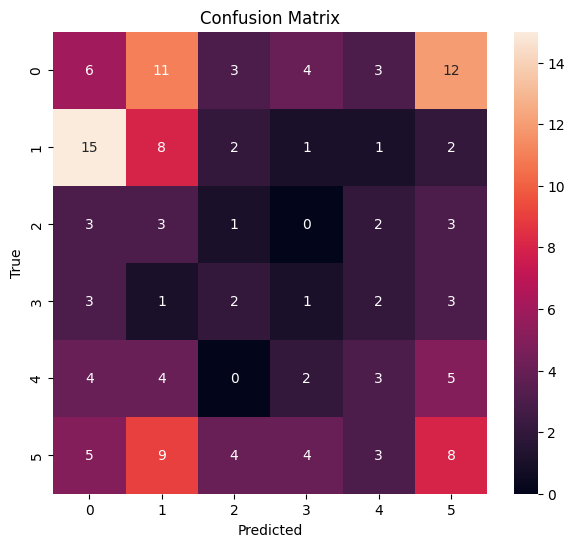

Class 0 F1: 0.160
Class 1 F1: 0.246
Class 2 F1: 0.083
Class 3 F1: 0.083
Class 4 F1: 0.188
Class 5 F1: 0.242


In [23]:
import pandas as pd
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

gt = pd.read_csv("../tasktwo_/data/train_folder/train/_classes.csv", sep=',')
sub_model = pd.read_csv("submission_mix.csv")

class_cols = ["Bear", "Bird", "Cat", "Dog", "Leopard", "Otter"]
gt[class_cols] = gt[class_cols].astype(int)
gt['label'] = gt[class_cols].idxmax(axis=1).map({
    "Bear":0, "Bird":1, "Cat":2, "Dog":3, "Leopard":4, "Otter":5
})

gt_subset = gt.iloc[:len(sub_model)].reset_index(drop=True)
y_true = gt_subset['label']
y_pred = sub_model['label'].astype(int)

macro_f1 = f1_score(y_true, y_pred, average='macro')
print("Macro F1 модели:", macro_f1)
print("Распределение предсказанных классов:")
print(y_pred.value_counts())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=range(6), yticklabels=range(6))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

f1_per_class = f1_score(y_true, y_pred, average=None)
for i, f1 in enumerate(f1_per_class):
    print(f"Class {i} F1: {f1:.3f}")
